In [15]:
# This file predicts Arrests using LogisticRegression (GridSearched to find best params).
# Dataset: crimes.csv merged with poverty.csv

In [6]:
import pandas as pd
import numpy as np
#!pip install pandas --upgrade
df = pd.read_csv('crimes.csv')

/Users/nishanthshanmugham/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [7]:
poverty = pd.read_csv('poverty.csv')
poverty = poverty.drop('COMMUNITY AREA NAME', 1)
poverty.head()

,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [8]:
# Remove unwanted columns from the data
# Add 'Date' back in when RJ fixes the datetime converter
useful_columns = ['IUCR', 'Location Description', 'Arrest', 'Domestic', 'Community Area', 'Year']
data = df[useful_columns]

In [9]:
# Merge with the poverty dataframe
data.rename(columns={'Community Area': 'Community Area Number'}, inplace=True)
data = pd.merge(data, poverty, how='right', on='Community Area Number')
data.head()

/Users/nishanthshanmugham/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2748: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [12]:
from sklearn.preprocessing import LabelEncoder
features = ['IUCR', 'Location Description', 'Arrest', 'Domestic']
for a in features:
    le = LabelEncoder()
    le.fit(data[a])
    data[a] = le.transform(data[a])
data.head()

,IUCR,Location Description,Arrest,Domestic,Community Area Number,Year,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,312,133,0,1,30.0,2012,15.2,30.7,15.8,54.8,33.8,10402,96.0
1,81,149,1,0,30.0,2012,15.2,30.7,15.8,54.8,33.8,10402,96.0
2,41,153,0,0,30.0,2012,15.2,30.7,15.8,54.8,33.8,10402,96.0
3,257,149,1,0,30.0,2012,15.2,30.7,15.8,54.8,33.8,10402,96.0
4,41,153,0,0,30.0,2012,15.2,30.7,15.8,54.8,33.8,10402,96.0


In [16]:
from sklearn.cross_validation import train_test_split

data = data.dropna()
X = data.drop(['Arrest'], axis=1)
y = data['Arrest'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

In [17]:
# Helper functions
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Arrest', 'Arrest'], rotation=45)
    plt.yticks(tick_marks, ['No Arrest', 'Arrest'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_roc(model):
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)
    predictions = [x[1] for x in predictions]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [18]:
# LogisticRegression with default params
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
logr = linear_model.LogisticRegression()
logr.fit(X_train, y_train)
prediction = logr.predict(X_test)

In [19]:
logr.score(X_test, y_test)

0.77267354298968105

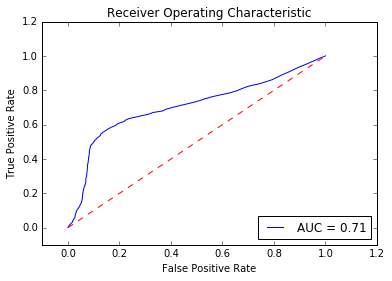

In [20]:
# ROC curve
plot_roc(logr)

In [ ]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, cmap=plt.cm.Greens)

In [22]:
# Metric for GridSearchCV
from sklearn.metrics import confusion_matrix
from __future__ import division
def cm_loss(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y, predictions)
    totals = np.sum(cm, 1)
    no_acc = cm[0, 0] / totals[0]
    yes_acc = cm[1, 1] / totals[1]
    return (no_acc + yes_acc)/2

In [14]:
# Don't run unless absolutely necessary

# GridSearchCV for best LR params
# Instead, consider copying the last line of the output and using it as the model
# WARN: takes 20 minutes–2 hours :)
from sklearn.grid_search import GridSearchCV
logr = LogisticRegression(n_jobs=-1, class_weight='balanced')
parameters = {'C':[.001, .01, 1, 5, 10], 'penalty': ['l2', 'l1']}
clf = GridSearchCV(logr, parameters, scoring=cm_loss, cv=5, verbose=100)
clf.fit(X_train, y_train)
print clf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] penalty=l2, C=0.001 .............................................
[CV] .................... penalty=l2, C=0.001, score=0.661383 -  25.1s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   25.2s
[CV] penalty=l2, C=0.001 .............................................
[CV] .................... penalty=l2, C=0.001, score=0.662341 -  25.5s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   50.8s
[CV] penalty=l2, C=0.001 .............................................
[CV] .................... penalty=l2, C=0.001, score=0.661261 -  24.8s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:  1.3min
[CV] penalty=l2, C=0.001 .............................................
[CV] .................... penalty=l2, C=0.001, score=0.663028 -  25.1s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:  1.7min
[CV] penalty=l2, C=0.001 .............................................
[CV] .................... penalty=l2, C=0.001, score

0.74569131179


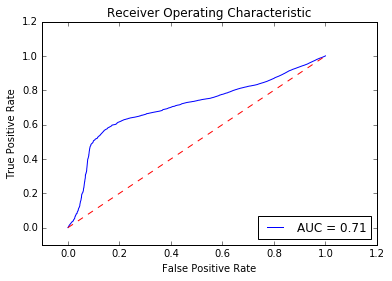

In [26]:
# TODO: Actually run GridSearchCV again with class_weight='balanced'.
best_logr = LogisticRegression(C=10, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
best_logr.fit(X_train, y_train)
prediction = best_logr.predict(X_test)
print best_logr.score(X_test, y_test)
plot_roc(best_logr)

In [ ]:
cm = confusion_matrix(prediction, y_test)
plot_confusion_matrix(cm, cmap=plt.cm.Greens)